## Introducción

Entrenamiento de modelo preentrenado para resolver el problema de predecir el ángulo del auto en base a la imagen.

Fuertemente basado en:
- https://towardsdatascience.com/a-practical-example-in-transfer-learning-with-pytorch-846bb835f2db
- https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html 

## Imports

In [1]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
from torchmetrics import MetricCollection, Accuracy, Precision, Recall, F1, ConfusionMatrix
import pandas as pd
import sklearn
from torch.utils.tensorboard import SummaryWriter

from datetime import datetime
import os

import importlib
import training_helper
from dataset_modules.one_part_dataset import OnePartDataset
import metrics_helper

importlib.reload(training_helper)
importlib.reload(metrics_helper)

<module 'metrics_helper' from '/Users/fcuevas/Documents/fing/tesis/jupyters/metrics_helper.py'>

## Variables

In [2]:
MODEL_NAME = "one_part_model"
EXPERIMENT_NAME = "resnet50_paragolpe_fine_tuning-augment"
FEATURE_EXTRACTION = False
parte = "Paragolpe Delantero"

device_string = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_string)

if device_string == "cuda":
    print("Usando GPU!")

os.makedirs("./trained_models/{}/{}/".format(MODEL_NAME, EXPERIMENT_NAME), exist_ok=True)

## Dataset

Se crea un dataset de tipo `ImageFolder` que se toma de la carpeta `dataset`, donde cada subcarpeta es una de las categorías a entrenar. 

Automáticamente mapea categorías a números `dataset.class_to_idx`.

Finalmente se hace el split en train y test en 80/20.

In [3]:
print("start to load dataset")
dataset = OnePartDataset(
    parte,
    transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    preload=False, # usar True en cluster
    visibility_file="./dataset_modules/analisis_manual_paragolpe.csv"
)
print("finish to load dataset")

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

classes = dataset.classes

dataset_sizes = {
    'train': len(train_dataset),
    'test': len(test_dataset)
}

print("#TRAIN {} #TEST {}".format(dataset_sizes["train"], dataset_sizes["test"]))

start to load dataset
M204933/M204933001.jpg False
M204933/M204933002.jpg False
M204933/M204933003.jpg False
M204933/M204933004.jpg False
M204933/M204933005.jpg False
M204933/M204933008.jpg False
M245982/M245982001.jpg False
M245982/M245982002.jpg False
M245982/M245982003.jpg False
M245982/M245982004.jpg False
M245997/M245997001.jpg False
M245997/M245997002.jpg False
M245997/M245997003.jpg False
M245997/M245997004.jpg False
M275046/M275046002.jpg False
M275046/M275046003.jpg False
M275046/M275046004.jpg False
M275046/M275046005.jpg False
M275053/M275053001.jpg False
M275053/M275053002.jpg False
M275053/M275053003.jpg False
M275053/M275053004.jpg True
M275054/M275054002.jpg False
M275054/M275054003.jpg False
M275054/M275054004.jpg False
M275054/M275054005.jpg False
M275054/M275054006.jpg False
M275054/M275054007.jpg False
M275062/M275062001.jpg True
M275062/M275062002.jpg True
M275062/M275062003.jpg False
M275062/M275062004.jpg False
M275070/M275070003.jpg False
M275070/M275070004.jpg F

In [35]:
from torchvision.datasets import VisionDataset

class ApplyTransform(VisionDataset):
    """
    Apply transformations to a Dataset

    Arguments:
        dataset (Dataset): A Dataset that returns (sample, target)
        transform (callable, optional): A function/transform to be applied on the sample
        target_transform (callable, optional): A function/transform to be applied on the target

    """
    def __init__(self, dataset, transform=None, target_transform=None):
        self.dataset = dataset
        self.transform = transform
        self.target_transform = target_transform
        # yes, you don't need these 2 lines below :(
        if transform is None and target_transform is None:
            print("Am I a joke to you? :)")

    def __getitem__(self, idx):
        sample, target, path = self.dataset[idx]
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return sample, target, path

    def __len__(self):
        return len(self.dataset)

In [36]:
transform = transforms.Compose([
    transforms.ColorJitter(0.5, 0.5, 0.5, 0.5),
    transforms.RandomRotation((-45, 45)),
    transforms.RandomInvert(p=0.1)
])

In [37]:
train_dataset = ApplyTransform(train_dataset, transform=transform)

## Loaders
Luego, se crean loaders para cada uno de los conjuntos. Los loaders permiten procesar los datos de a batches.

In [38]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=0
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=0
)

dataloaders = {
    'train': train_loader,
    'test': test_loader
}

## Entrenamiento

En este step se carga el modelo pre-entrenado. Para este ejemplo se utiliza el modelo alexnet por su simplicidad.

#### ¿Finetuning o Feature extraction?

- **Finetuning:** Consiste en incializar la red con los pesos pre-entrenados, y re-entrenar toda la red (ajustar los parámetros de todas las capas) con el dataset custom.
- **Feature extraction:** La diferencia con lo anterior es que se congelan las capas convolucionales, de modo que el entrenamiento no las cambie con nuestros datos.

En ambos casos pisamos la capa de **clasificador** por una capa nueva con 8 categorías, porque el modelo pre-entrenado tiene 1000 labels.

In [39]:
model = models.resnet50(pretrained=True)
NUM_CLASSES = len(classes)

if FEATURE_EXTRACTION:
    for param in model.parameters():
        param.requires_grad = False

model.fc = torch.nn.Linear(2048, NUM_CLASSES)
model = model.to(device)

# Tensorboard metrics writer
writer = SummaryWriter(log_dir='./trained_models/{}/tensorboard/{}'.format(MODEL_NAME, EXPERIMENT_NAME + '-' + datetime.now().strftime("%Y%m%d-%H%M%S")))

# Función de error
criterion = F.cross_entropy

# Optimizador
parameters_to_update = model.parameters()

if FEATURE_EXTRACTION:
    parameters_to_update = model.fc.parameters()

optimizer = optim.SGD(parameters_to_update, lr=0.001)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [40]:
model = training_helper.train_model(
    model, 
    criterion, 
    optimizer, 
    dataloaders, 
    dataset_sizes, 
    device, 
    writer, 
    NUM_CLASSES,
    'trained_models/{}/{}'.format(MODEL_NAME, EXPERIMENT_NAME),
    main_metric='macro_f1', 
    num_epochs=25
)

Epoch 0/24
----------


KeyboardInterrupt: 

In [8]:
BEST_MODEL_PATH = './trained_models/{}/{}/best_model.pth'.format(MODEL_NAME, EXPERIMENT_NAME)
os.makedirs(os.path.dirname(BEST_MODEL_PATH), exist_ok=True)
torch.save(model.state_dict(), BEST_MODEL_PATH)

## Evaluación final

In [9]:
from dataset_modules.common import pil_loader
model.load_state_dict(torch.load(BEST_MODEL_PATH))
model.eval()

metrics = metrics_helper.init_metrics(device, NUM_CLASSES)
tensorboard_transforms = transforms.Compose([
    transforms.ToTensor()
])

total_loss = 0.0

for i, (images, labels, imgs_path) in enumerate(test_loader):
    images = images.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        metrics(outputs, labels)
        
        predictions = torch.argmax(outputs, dim=1)
        loss = criterion(outputs, labels)
        
        total_loss += loss.item() * images.size(0)
        
        for sampleno in range(images.shape[0]):
            if(labels[sampleno] != predictions[sampleno]):
                name = 'Misclasified_Predicted-{}_Classified-{}/{}'.format(classes[predictions[sampleno]], classes[labels[sampleno]], imgs_path[sampleno])
                
                writer.add_image(name, tensorboard_transforms(pil_loader('/scratch/franco.cuevas/imgs/' + imgs_path[sampleno])))
                writer.flush()
        
total_loss /= dataset_sizes["test"]

metrics_result = metrics.compute()

In [10]:
macro_metrics = metrics_helper.generate_macro_metrics(metrics_result, total_loss)
per_class_metrics = metrics_helper.generate_per_class_metrics(metrics_result, classes)

macro_metrics.to_csv('./trained_models/{}/{}/best_model_macro_metrics.csv'.format(MODEL_NAME, EXPERIMENT_NAME), index=False)
per_class_metrics.to_csv('./trained_models/{}/{}/best_model_per_class_metrics.csv'.format(MODEL_NAME, EXPERIMENT_NAME), index=False)

------------------------- GENERAL METRICS -------------------------

Loss 0.3518374412804395
Micro Accuracy 0.8528528809547424
Macro Accuracy 0.7806064486503601
Macro Precision 0.772459089756012
Macro Recall 0.7806064486503601
Macro F1 0.7806064486503601

------------------------- PER CLASS METRICS -------------------------


,class,accuracy,precision,recall,f1
0,paragolpe_delantero_roto,0.684932,0.684932,0.684932,0.684932
1,paragolpe_delantero_sano,0.687500,0.637681,0.687500,0.687500
2,no_paragolpe_delantero,0.969388,0.994764,0.969388,0.969388


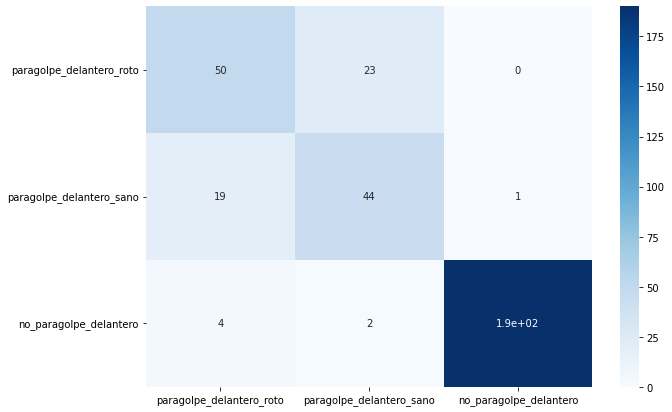

In [11]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(metrics_result['confusion_matrix'], index = classes,
                  columns = classes)

df_cm = df_cm.applymap(lambda x: x.item())

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="Blues")
df_cm.to_csv('./trained_models/{}/{}/confusion_matrix.csv'.format(MODEL_NAME, EXPERIMENT_NAME))